<a href="https://colab.research.google.com/github/JoaoAlexandreFerreira/RNA/blob/main/PINN_buckley_leverett.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [81]:
pip install --upgrade pyDOE

In [82]:
import tensorflow as tf
from scipy.io import loadmat
import numpy as np
import keras
import matplotlib.pyplot as plt
import pandas as pd
from keras import Sequential
from keras.layers import Input, Dense
from time import time
from keras.optimizers import Adam
from keras.initializers import Ones, GlorotNormal, he_normal, Zeros, GlorotUniform
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
from pyDOE import lhs
from mpl_toolkits.axes_grid1 import make_axes_locatable
import scipy.optimize

In [83]:
keras.backend.set_floatx('float32')
tf.random.set_seed(1234)
#Definindo os parametros, começando pela viscosidade do óleo e da agua
u_o= 0.8
u_w= 1.e-3
#Porosidade
por=0.24
#Saturação irredutível de água
Swi = 0.15
#Saturação de óleo residual no meio poroso
Swo = 0.2
qt = 0.2
Area = 1
#Definindo as condições de contorno e inicial
def inicial(x):
  return tf.constant(0., shape = (x.shape[0], 1))

def contorno(t, x):
  n = x.shape[0]
  return tf.where(tf.equal(x, 0), tf.ones((n, 1)), tf.zeros((n, 1)))

#função do fluxo fracionario de água, em função da saturação de agua e da mobilidade
def fw(u,M):
  return (u**2)/((u**2) + ((1-u)**2)/M)

#Definindo os pontos X
N_0 = 300 #100 pontos para condição inicial
N_b = 300 #100 pontos para condição de contorno
N_r = 10000 #Pontos para a edp

#Pontos do domínio
tmin = 0. ; tmax = 1.
xmin = 0.; xmax = 1.

#Ponto inferior e superior, respectivamente
lb = tf.constant([tmin, xmin]); ub = tf.constant([tmax, xmax])

#Obtendo pontos para a condição inicial
t0 = tf.zeros((N_0,1))*lb[0]
x0 = tf.random.uniform((N_0,1), lb[1], ub[1]) #Colocando os valores de x0 em ordem aleatoria, indo de -1 a 1
x0 = tf.concat([t0, x0], 1) #Criando uma matriz com os valores de tempo = 0 e de x0

#Valores de u para a condição inicial
u_ini = inicial(x0[:,1:2])

#Repetindo o processo, mas para a condição de contorno
tb = tf.random.uniform((N_b,1), lb[0], ub[0])
xb = lb[1] + (ub[1] - lb[1]) * keras.backend.random_bernoulli((N_b,1), 0.5)
#xb = tf.zeros((N_b,1))*lb[1]
xb = tf.concat([tb, xb], 1)

#Valores na condição de contorno
u_cont = contorno(xb[:,0:1], xb[:,1:2])

#Repetindo o processo, mas agora é para obter os pontos da EDP
tr = tf.random.uniform((N_r,1), lb[0], ub[0])
xr = tf.random.uniform((N_r,1), lb[1], ub[1])
xr = tf.concat([tr, xr], 1)

#Fazendo uma lista, para uso posterior
X_cond = [x0, xb]
u_cond = [u_ini, u_cont]

#Realizando plotagem dos pontos que são usados para condição de contorno, inicial e para edp

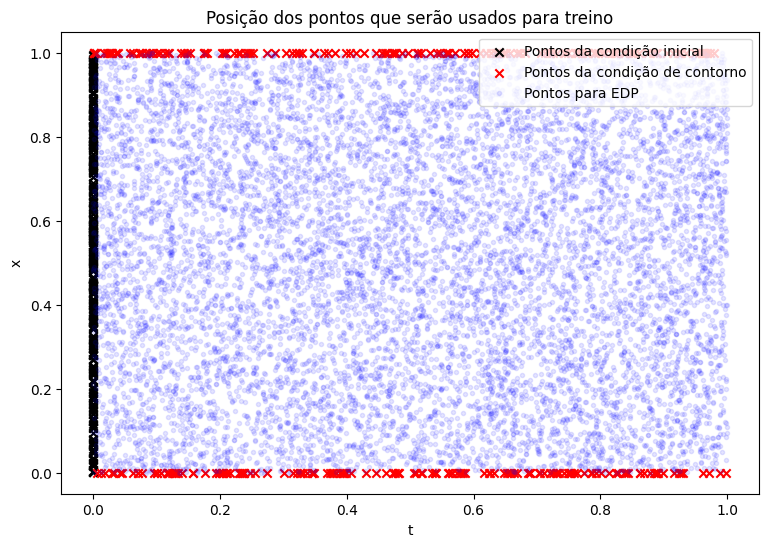

In [84]:
plt.figure(figsize=(9,6))
plt.scatter(x0[:,0:1],x0[:,1:2], c='black', marker ='x')
plt.scatter(xb[:,0:1],xb[:,1:2], c='red', marker ='x')
plt.scatter(xr[:,0:1], xr[:,1:2], c='blue', marker = '.', alpha = 0.1)
plt.xlabel('t'); plt.ylabel('x')
plt.title('Posição dos pontos que serão usados para treino')
plt.legend(['Pontos da condição inicial', 'Pontos da condição de contorno', 'Pontos para EDP'])
plt.show()

In [85]:
#criando o modelo de Rede neural

def modelopinn(nos, camadas_ocultas):
  modelo = Sequential()
  #Inserindo o numero de variaveis de entrada
  modelo.add(Input(2))
  modelo.add(keras.layers.Lambda(
      lambda x: 2.0*(x - lb)/(ub - lb) - 1.0
  ))

  for i in range(camadas_ocultas):
        modelo.add(Dense(nos, activation='tanh', kernel_initializer=GlorotUniform()))

  modelo.add(Dense(1))
  modelo.summary()
  return modelo

#Sem o fator de correção, i.e, $ϵ$ =0.001*u_xx

In [86]:
#E tirando os gradientes, para calcular a edp
def gradiente(modelo, X_r):
  with tf.GradientTape(persistent=True) as tape:
    t, x = X_r[:, 0:1], X_r[:,1:2]
    tape.watch(t)
    tape.watch(x)
    u = modelo(tf.stack([t[:,0], x[:,0]], 1))
    tape.watch(u)

    k_rw = ((u - Swi)/(1-Swi-Swo))**2
    k_ro = ((1- u - Swi)/(1-Swi-Swo))**2
    #f = (k_rw/u_w)/((k_rw/u_w) + (k_ro/u_o))
    #f = 1/(1+(k_ro/u_w)*(u_o/k_rw))
    f = fw(u, 2)
    f_u = tape.gradient(f,u)
    f_x = tape.gradient(f,x)

    ux = tape.gradient(u, x)
    ut = tape.gradient(u, t)
    uxx = tape.gradient(ux, x)

  del tape

  return ut + f_u*ux
  #return ut + f_x

def MSE(modelo, xr, X_cond, u_cond):

    #Erro edp
    r = gradiente(modelo, xr)
    erro = tf.reduce_mean(tf.square(r))

    loss = erro

    #Erro da rede neural
    for i in range(len(X_cond)):
        u_pred = modelo(X_cond[i])
        loss += tf.reduce_mean(tf.square(u_cond[i] - u_pred))

    return erro, loss

def grad(modelo, xr, X_cond, u_cond):
  with tf.GradientTape(persistent=True) as tape:
    tape.watch(modelo.trainable_variables)
    erro, loss = MSE(modelo, xr, X_cond, u_cond)

  g = tape.gradient(loss, modelo.trainable_variables)
  del tape

  return erro, loss, g

In [87]:
modelosc = modelopinn(20,9)

lr = tf.keras.optimizers.schedules.PiecewiseConstantDecay([1000,3000],[1e-2,1e-3,5e-4])

otimizador = Adam(learning_rate = lr)

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda_12 (Lambda)          (None, 2)                 0         
                                                                 
 dense_110 (Dense)           (None, 20)                60        
                                                                 
 dense_111 (Dense)           (None, 20)                420       
                                                                 
 dense_112 (Dense)           (None, 20)                420       
                                                                 
 dense_113 (Dense)           (None, 20)                420       
                                                                 
 dense_114 (Dense)           (None, 20)                420       
                                                                 
 dense_115 (Dense)           (None, 20)               

In [88]:
@tf.function
def train_step(modelo):
  erro, loss, grad_theta = grad(modelo, xr, X_cond, u_cond)

  otimizador.apply_gradients(zip(grad_theta, modelo.trainable_variables))

  return erro, loss

itr = 5000
historico = []
erro_aux = []
t0 = time()

for i in range(itr+1):

    erro, loss = train_step(modelosc)

    #Salvando os erros para listar
    historico.append(loss.numpy())
    erro_aux.append(erro.numpy)

    if i%1 == 0:
        print(i,"Loss treino: {:10.8e}, Loss edp: {:10.8e}".format(loss, erro))

print('\nTempo de treino da rede neural: {} segundos'.format(time()-t0))

A saída de streaming foi truncada nas últimas 5000 linhas.
3 Loss treino: 5.07822871e-01, Loss edp: 3.34093324e-03
4 Loss treino: 3.99254471e-01, Loss edp: 1.45054152e-02
5 Loss treino: 6.84792638e-01, Loss edp: 3.92284006e-01
6 Loss treino: 4.79974270e-01, Loss edp: 1.17755421e-01
7 Loss treino: 4.92868304e-01, Loss edp: 2.62215324e-02
8 Loss treino: 4.85161841e-01, Loss edp: 1.00012356e-02
9 Loss treino: 4.22923356e-01, Loss edp: 4.50265920e-03
10 Loss treino: 3.96187484e-01, Loss edp: 2.27763206e-02
11 Loss treino: 3.93858165e-01, Loss edp: 3.39331143e-02
12 Loss treino: 3.75435799e-01, Loss edp: 2.38436796e-02
13 Loss treino: 3.32270414e-01, Loss edp: 1.33972783e-02
14 Loss treino: 2.76403785e-01, Loss edp: 1.61341894e-02
15 Loss treino: 2.47078836e-01, Loss edp: 3.68017294e-02
16 Loss treino: 2.72056341e-01, Loss edp: 8.18296596e-02
17 Loss treino: 2.58751392e-01, Loss edp: 9.34532881e-02
18 Loss treino: 2.16138288e-01, Loss edp: 6.03510253e-02
19 Loss treino: 2.51458883e-01, Loss

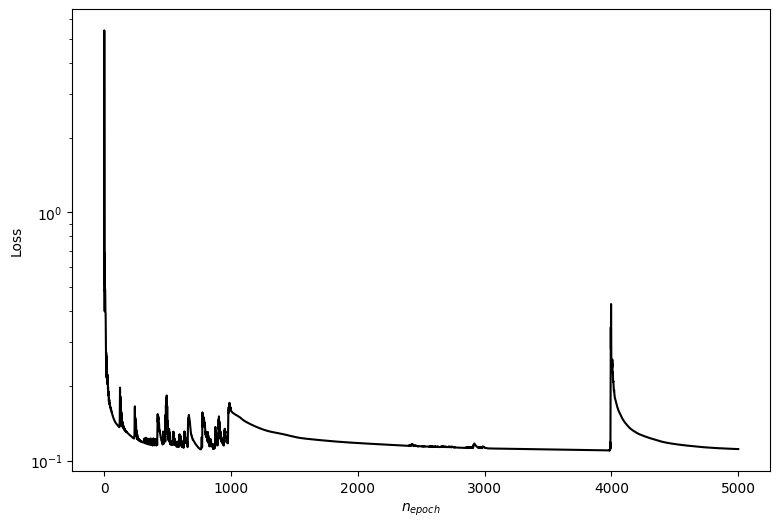

In [89]:
fig = plt.figure(figsize=(9,6))
ax = fig.add_subplot(111)
ax.semilogy(range(len(historico)), historico,'k-')
ax.set_xlabel('$n_{epoch}$')
ax.set_ylabel('Loss');
plt.show()

In [90]:
N = 600
tspace = np.linspace(lb[0], ub[0], N + 1)
xspace = np.linspace(lb[1], ub[1], N + 1)
T, X = np.meshgrid(tspace, xspace)
Xgrid = np.vstack([T.flatten(),X.flatten()]).T

#Realizando predição
upred = modelosc(Xgrid)

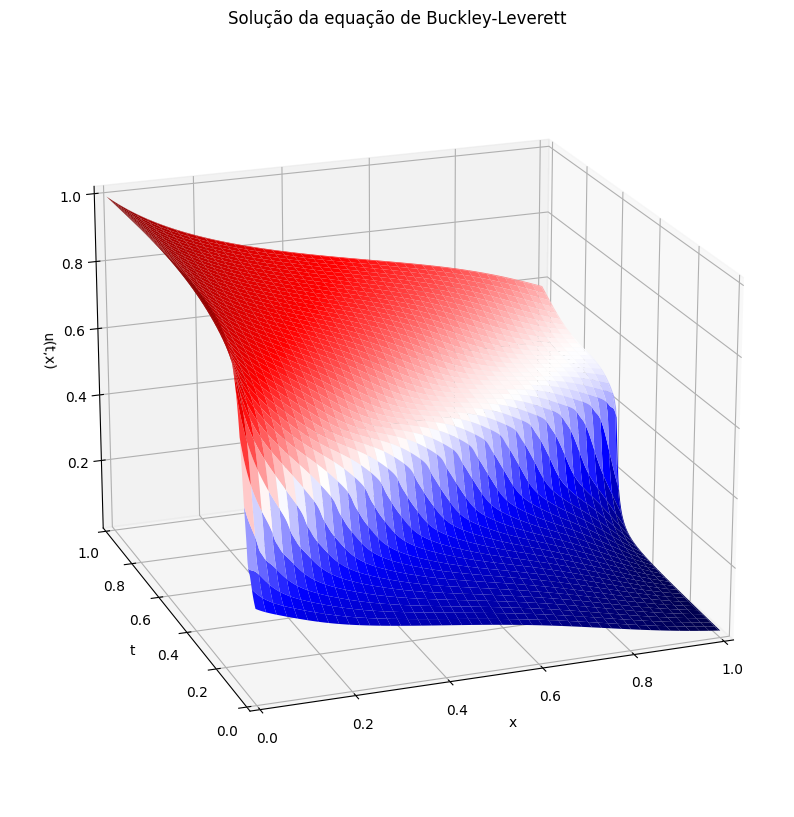

In [91]:
U = upred.numpy().reshape(N+1,N+1)
fig = plt.figure(figsize=(10,12))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, T, U, cmap='seismic');
ax.view_init(20,70)
ax.set_xlim(1,0)
ax.set_ylim(1,0)
ax.set_xlabel('x')
ax.set_ylabel('t')
ax.set_zlabel('u(t,x)')
ax.set_title('Solução da equação de Buckley-Leverett');
plt.show()

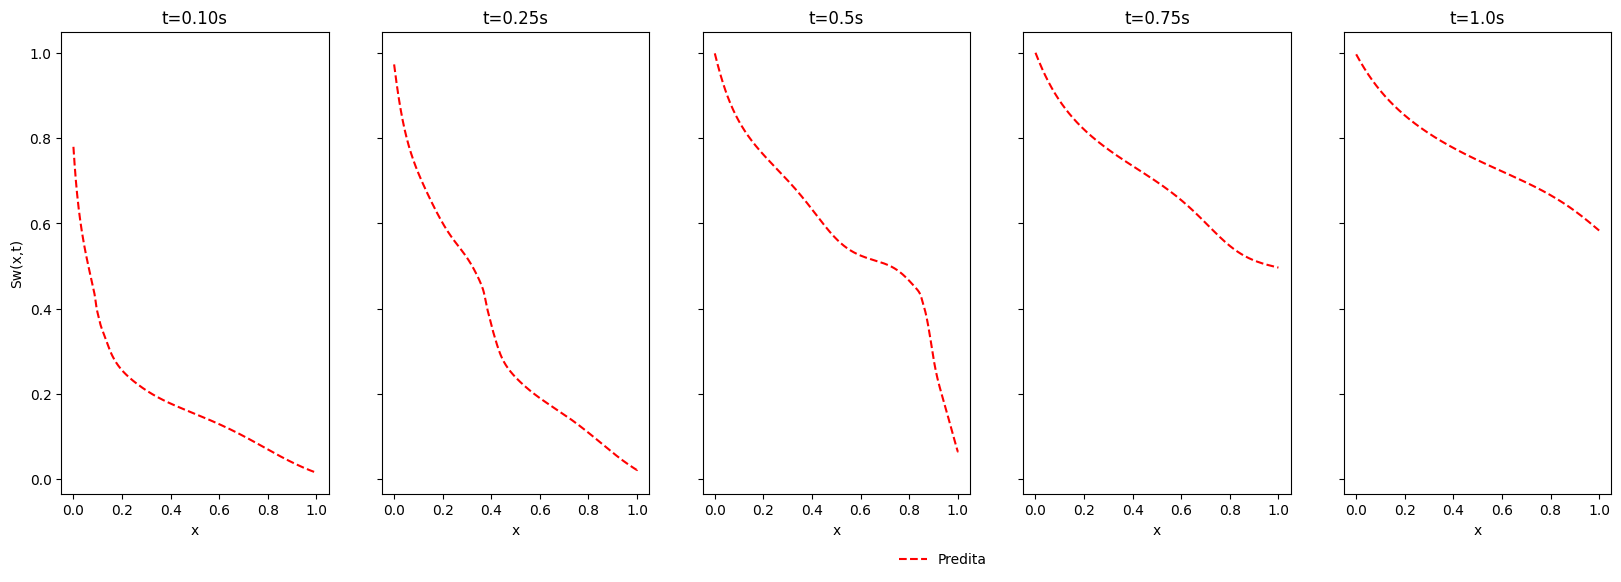

In [92]:
xspace = np.linspace(lb[1], ub[1], N + 1)

t_ini = np.ones((N+1))*0.10
T, X = np.meshgrid(t_ini, xspace)
X0 = np.vstack([T.flatten(),X.flatten()]).T

t_025 = np.ones((N+1))*0.25
T, X = np.meshgrid(t_025, xspace)
X050 = np.vstack([T.flatten(),X.flatten()]).T

t_050 = np.ones((N+1))*0.50
T, X = np.meshgrid(t_050, xspace)
X1 = np.vstack([T.flatten(),X.flatten()]).T

t_075 = np.ones((N+1))*0.75
T, X = np.meshgrid(t_075, xspace)
X15 = np.vstack([T.flatten(),X.flatten()]).T

t_1 = np.ones((N+1))*1
T, X = np.meshgrid(t_1, xspace)
X2 = np.vstack([T.flatten(),X.flatten()]).T

fig, axs = plt.subplots(1, 5, figsize=(20,6) ,sharey=True)

#axs[0].plot(xspaceana, Temp[int(t_ini[0]*passos/tmax)], c='b', label = 'Exata')
axs[0].plot(X0[:,1], modelosc(X0).numpy(), linestyle ='dashed', color='r', label = 'Predita')
axs[0].set_title('t=0.10s')
axs[0].set_xlabel('x')
axs[0].set_ylabel('Sw(x,t)')

#axs[1].plot(xspaceana, Temp[int(t_050[0]*passos/tmax)], c='b', label = 'Exata')
axs[1].plot(X050[:,1], modelosc(X050).numpy(),linestyle='dashed', color='r', label = 'Predita')
axs[1].set_title('t=0.25s')
axs[1].set_xlabel('x')

#axs[2].plot(xspaceana, Temp[int(t_1[0]*passos/tmax)], c='b', label = 'Exata')
axs[2].plot(X1[:,1], modelosc(X1).numpy(), linestyle='dashed',color='r', label = 'Predita')
axs[2].set_title('t=0.5s')
axs[2].set_xlabel('x')

#axs[3].plot(xspaceana, Temp[int(t_2[0]*passos/tmax)-1], c='b', label = 'Exata')
axs[3].plot(X2[:,1], modelosc(X15).numpy(), linestyle='dashed',color='r', label = 'Predita')
axs[3].set_title('t=0.75s')
axs[3].set_xlabel('x')

axs[4].plot(X2[:,1], modelosc(X2).numpy(), linestyle='dashed',color='r', label = 'Predita')
axs[4].set_title('t=1.0s')
axs[4].set_xlabel('x')


plt.legend(
    loc='upper center',
    bbox_to_anchor=(-1.5, -0.10),
    ncol=5,
    frameon=False
)
plt.show()

In [102]:
class PINN_Arquitetura(keras.Model):

    def __init__(self, lb, ub,
            saida=1,
            camadas_ocultas=9,
            nos_ocultos=20,
            activation='tanh',
            kernel_initializer='glorot_uniform',
            **kwargs):
        super().__init__(**kwargs)

        self.camadas_ocultas = camadas_ocultas
        self.saida = saida
        self.lb = lb
        self.ub = ub


        self.scale = keras.layers.Lambda(
            lambda x: 2.0*(x - lb)/(ub - lb) - 1.0)
        self.hidden = [Dense(nos_ocultos,
                             activation=keras.activations.get(activation),
                             kernel_initializer=kernel_initializer)
                           for _ in range(self.camadas_ocultas)]
        self.out = Dense(saida)

    def call(self, X):

        Z = self.scale(X)
        for i in range(self.camadas_ocultas):
            Z = self.hidden[i](Z)
        return self.out(Z)


In [103]:
class PINN():
    def __init__(self, modelo, X_r):
        self.modelo = modelo

        #pontos de colocação da edp
        self.t = X_r[:,0:1]
        self.x = X_r[:,1:2]

        #histórico de perdas e o contador global de iterações
        self.hist = []
        self.iter = 0

    def gradiente(self):
      #Registrando tempo e posição para a diferenciação automática
        with tf.GradientTape(persistent=True) as tape:
          tape.watch(self.t)
          tape.watch(self.x)
          u = modelo(tf.stack([self.t[:,0], self.x[:,0]], axis=1))
          tape.watch(u)

          k_rw = ((u - Swi)/(1-Swi-Swo))**2
          k_ro = ((1- u - Swi)/(1-Swi-Swo))**2
          #f = (k_rw/u_w)/((k_rw/u_w) + (k_ro/u_o))
          f = fw(u, 2)
          f_u = tape.gradient(f,u)
          f_x = tape.gradient(f,self.x)

          ux = tape.gradient(u, self.x)
          ut = tape.gradient(u, self.t)
          uxx = tape.gradient(ux, self.x)

        del tape

        #return ut + ux*f_u
        return ut+f_x

    def MSE(self, X, u):
      #Erro edp
        r = self.gradiente()
        erro = tf.reduce_mean(tf.square(r))

        loss = erro
        #Erro da rede neural
        for i in range(len(X)):
            u_pred = self.modelo(X[i])
            loss += tf.reduce_mean(tf.square(u[i] - u_pred))

        return erro, loss

    def grad(self, X, u):
      #tirando o gradiente em relação ao modelos, para que eles sejam atualizados posteriormente
        with tf.GradientTape(persistent=True) as tape:
            tape.watch(self.modelo.trainable_variables)
            erro, loss = self.MSE(X, u)

        g = tape.gradient(loss, self.modelo.trainable_variables)
        del tape

        return erro, loss, g


    def treino(self, X, u, method='L-BFGS-B', **kwargs):

        def get_weight_tensor():
            #Função para retornar variáveis atuais do modelo como tensor 1d, bem como formas correspondentes como listas.

            weight_list = []
            shape_list = []

            #loop sobre todas as variáveis, ou seja, matrizes de peso + bias e parâmetros desconhecidos
            for v in self.modelo.variables:
                shape_list.append(v.shape)
                weight_list.extend(v.numpy().flatten())

            weight_list = tf.convert_to_tensor(weight_list)
            return weight_list, shape_list

        x0, shape_list = get_weight_tensor()

        def set_weight_tensor(weight_list):
            #Função que define lista de pesos para variáveis do modelo.
            idx = 0
            for v in self.modelo.variables:
                vs = v.shape

                #Matriz do peso
                if len(vs) == 2:
                    sw = vs[0]*vs[1]
                    new_val = tf.reshape(weight_list[idx:idx+sw],(vs[0],vs[1]))
                    idx += sw

                #Vetor bias
                elif len(vs) == 1:
                    new_val = weight_list[idx:idx+vs[0]]
                    idx += vs[0]

                #Variáveis (no caso de configuração de identificação de parâmetro)
                elif len(vs) == 0:
                    new_val = weight_list[idx]
                    idx += 1

                #Atribuir variáveis (cast necessário, pois o scipy requer o tipo float64)
                v.assign(tf.cast(new_val, 'float32'))

        def get_loss_and_grad(w):
            #Função que fornece perda de custo e gradiente em relação às variáveis ​​treináveis ​​como vetor.

            #Atualizar os pesos
            set_weight_tensor(w)
            #Determinar o custo da rede neural
            erro, loss, grad = self.grad(X, u)

            #Armazenando o custo atual para a função de retorno
            loss = loss.numpy().astype(np.float64)
            self.current_loss = loss

            #Salvando os valores do gradiente
            grad_flat = []
            for g in grad:
                grad_flat.extend(g.numpy().flatten())

            #Convertendo para array
            grad_flat = np.array(grad_flat,dtype=np.float64)

            #Retornando o custo e o gradiente
            return loss, grad_flat

        #retorno, minimizando o gradiente
        return scipy.optimize.minimize(fun=get_loss_and_grad,
                                       x0=x0,
                                       jac=True,
                                       method=method,
                                       callback=self.callback,
                                       **kwargs)

    def callback(self, xr=None):
      if self.iter % 50 == 0:
        print('It {:05d}: loss = {:10.8e}'.format(self.iter,self.current_loss))
      self.hist.append(self.current_loss)
      self.iter+=1


    def solucao(self, **kwargs):
      N = 600
      tspace = np.linspace(self.modelo.lb[0], self.modelo.ub[0], N+1)
      xspace = np.linspace(self.modelo.lb[1], self.modelo.ub[1], N+1)
      T, X = np.meshgrid(tspace, xspace)
      Xgrid = np.vstack([T.flatten(),X.flatten()]).T

      #Realizando predição
      upred = self.modelo(tf.cast(Xgrid,'float32'))

      U = upred.numpy().reshape(N+1,N+1)

      fig = plt.figure(figsize=(10,12))
      ax = fig.add_subplot(111, projection='3d')
      ax.plot_surface(X, T, U, cmap='seismic');
      ax.view_init(20,70)
      ax.set_xlim(1,0)
      ax.set_ylim(1,0)
      ax.set_xlabel('x')
      ax.set_ylabel('t')
      ax.set_zlabel('u(t,x)')
      ax.set_title('Solução da equação de Buckley-Leverett');
      return ax

    def custo(self, ax=None):
      if not ax:
        fig = plt.figure(figsize=(7,5))
        ax = fig.add_subplot(111)
      ax.semilogy(range(len(self.hist)), self.hist,'k-')
      ax.set_xlabel('x')
      ax.set_ylabel('Loss')
      return ax

    def plot_momentos(self, **kwargs):
      N= 600
      xspace = np.linspace(self.modelo.lb[1], self.modelo.ub[1], N + 1)

      t_ini = np.ones((N+1))*0.10
      T, X = np.meshgrid(t_ini, xspace)
      X0 = np.vstack([T.flatten(),X.flatten()]).T

      t_025 = np.ones((N+1))*0.25
      T, X = np.meshgrid(t_025, xspace)
      X050 = np.vstack([T.flatten(),X.flatten()]).T

      t_050 = np.ones((N+1))*0.50
      T, X = np.meshgrid(t_050, xspace)
      X1 = np.vstack([T.flatten(),X.flatten()]).T

      t_075 = np.ones((N+1))*0.75
      T, X = np.meshgrid(t_075, xspace)
      X15 = np.vstack([T.flatten(),X.flatten()]).T

      t_1 = np.ones((N+1))*1
      T, X = np.meshgrid(t_1, xspace)
      X2 = np.vstack([T.flatten(),X.flatten()]).T

      fig, axs = plt.subplots(1, 5, figsize=(20,6) ,sharey=True)

      #axs[0].plot(xspaceana, Temp[int(t_ini[0]*passos/tmax)], c='b', label = 'Exata')
      axs[0].plot(X0[:,1], modelosc(X0).numpy(), linestyle ='dashed', color='r', label = 'Predita')
      axs[0].set_title('t=0.10s')
      axs[0].set_xlabel('x')
      axs[0].set_ylabel('Sw(x,t)')

      #axs[1].plot(xspaceana, Temp[int(t_050[0]*passos/tmax)], c='b', label = 'Exata')
      axs[1].plot(X050[:,1], modelosc(X050).numpy(),linestyle='dashed', color='r', label = 'Predita')
      axs[1].set_title('t=0.25s')
      axs[1].set_xlabel('x')

      #axs[2].plot(xspaceana, Temp[int(t_1[0]*passos/tmax)], c='b', label = 'Exata')
      axs[2].plot(X1[:,1], modelosc(X1).numpy(), linestyle='dashed',color='r', label = 'Predita')
      axs[2].set_title('t=0.5s')
      axs[2].set_xlabel('x')

      #axs[3].plot(xspaceana, Temp[int(t_2[0]*passos/tmax)-1], c='b', label = 'Exata')
      axs[3].plot(X2[:,1], modelosc(X15).numpy(), linestyle='dashed',color='r', label = 'Predita')
      axs[3].set_title('t=0.75s')
      axs[3].set_xlabel('x')

      axs[4].plot(X2[:,1], modelosc(X2).numpy(), linestyle='dashed',color='r', label = 'Predita')
      axs[4].set_title('t=1.0s')
      axs[4].set_xlabel('x')


      plt.legend(
          loc='upper center',
          bbox_to_anchor=(-1.5, -0.10),
          ncol=5,
          frameon=False)
      plt.show()
      return axs

In [107]:
modelo = PINN_Arquitetura(lb, ub)
modelo.build(input_shape=(None,2))

modelo_pinnsc = PINN(modelo, xr)

t0 = time()
modelo_pinnsc.treino(X_cond, u_cond,
                            method='L-BFGS-B',
                            options={'maxiter': 50000,
                                     'maxfun': 50000,
                                     'maxcor': 50,
                                     'maxls': 50,
                                     'ftol': 1.0*np.finfo(float).eps})

print('\nTempo de treino da rede neural: {} segundos'.format(time()-t0))

It 00000: loss = 4.64263499e-01
It 00050: loss = 1.47058368e-01
It 00100: loss = 1.31168917e-01
It 00150: loss = 1.22060329e-01
It 00200: loss = 1.16856605e-01
It 00250: loss = 1.14761338e-01
It 00300: loss = 1.12827756e-01
It 00350: loss = 1.10696211e-01
It 00400: loss = 1.08859904e-01
It 00450: loss = 1.07674628e-01
It 00500: loss = 1.05986662e-01
It 00550: loss = 1.05052620e-01
It 00600: loss = 1.04295366e-01
It 00650: loss = 1.03692941e-01
It 00700: loss = 1.03235215e-01
It 00750: loss = 1.03022337e-01
It 00800: loss = 1.02790244e-01
It 00850: loss = 1.02626383e-01
It 00900: loss = 1.02449358e-01
It 00950: loss = 1.02347702e-01
It 01000: loss = 1.02257706e-01
It 01050: loss = 1.02167100e-01
It 01100: loss = 1.02081761e-01
It 01150: loss = 1.01949193e-01
It 01200: loss = 1.01807073e-01
It 01250: loss = 1.01641811e-01
It 01300: loss = 1.01440020e-01
It 01350: loss = 1.01217210e-01
It 01400: loss = 1.01036660e-01
It 01450: loss = 1.00877024e-01
It 01500: loss = 1.00691482e-01
It 01550

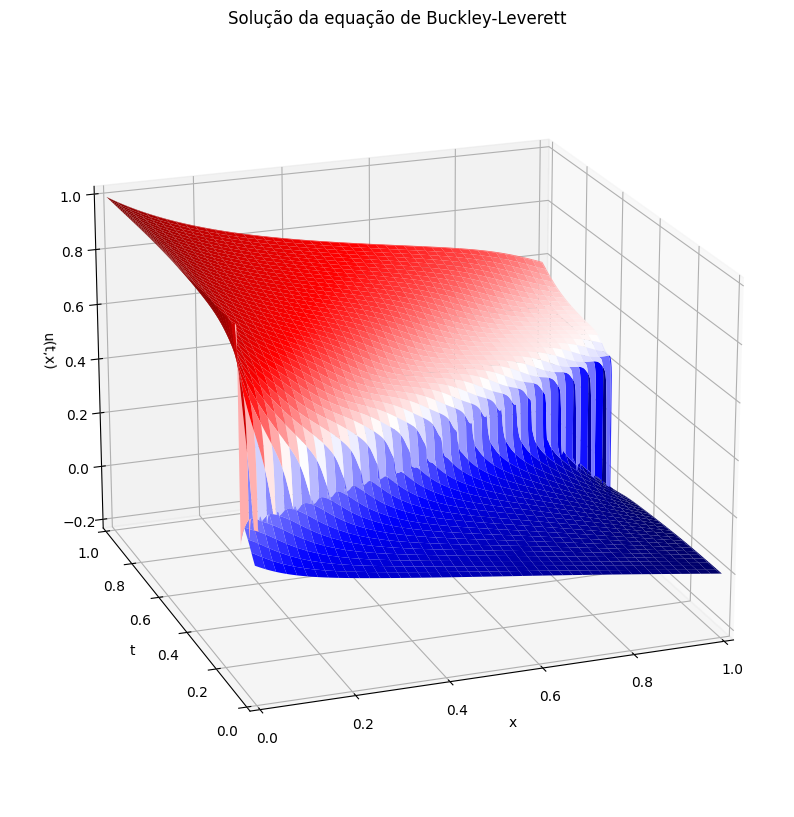

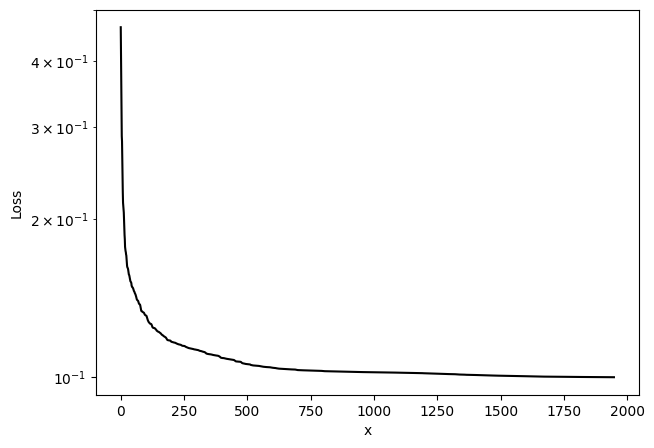

In [108]:
modelo_pinnsc.solucao();
modelo_pinnsc.custo();

In [109]:
def plot_momentos(**kwargs):
      N= 600
      xspace = np.linspace(0, 1, N + 1)

      t_ini = np.ones((N+1))*0.10
      T, X = np.meshgrid(t_ini, xspace)
      X0 = np.vstack([T.flatten(),X.flatten()]).T

      t_025 = np.ones((N+1))*0.25
      T, X = np.meshgrid(t_025, xspace)
      X050 = np.vstack([T.flatten(),X.flatten()]).T

      t_050 = np.ones((N+1))*0.50
      T, X = np.meshgrid(t_050, xspace)
      X1 = np.vstack([T.flatten(),X.flatten()]).T

      t_075 = np.ones((N+1))*0.75
      T, X = np.meshgrid(t_075, xspace)
      X15 = np.vstack([T.flatten(),X.flatten()]).T

      t_1 = np.ones((N+1))*1
      T, X = np.meshgrid(t_1, xspace)
      X2 = np.vstack([T.flatten(),X.flatten()]).T

      fig, axs = plt.subplots(1, 5, figsize=(20,6) ,sharey=True)

      #axs[0].plot(xspaceana, Temp[int(t_ini[0]*passos/tmax)], c='b', label = 'Exata')
      axs[0].plot(X0[:,1], modelosc(X0).numpy(), linestyle ='dashed', color='r', label = 'Predita')
      axs[0].set_title('t=0.10s')
      axs[0].set_xlabel('x')
      axs[0].set_ylabel('Sw(x,t)')

      #axs[1].plot(xspaceana, Temp[int(t_050[0]*passos/tmax)], c='b', label = 'Exata')
      axs[1].plot(X050[:,1], modelosc(X050).numpy(),linestyle='dashed', color='r', label = 'Predita')
      axs[1].set_title('t=0.25s')
      axs[1].set_xlabel('x')

      #axs[2].plot(xspaceana, Temp[int(t_1[0]*passos/tmax)], c='b', label = 'Exata')
      axs[2].plot(X1[:,1], modelosc(X1).numpy(), linestyle='dashed',color='r', label = 'Predita')
      axs[2].set_title('t=0.5s')
      axs[2].set_xlabel('x')

      #axs[3].plot(xspaceana, Temp[int(t_2[0]*passos/tmax)-1], c='b', label = 'Exata')
      axs[3].plot(X2[:,1], modelosc(X15).numpy(), linestyle='dashed',color='r', label = 'Predita')
      axs[3].set_title('t=0.75s')
      axs[3].set_xlabel('x')

      axs[4].plot(X2[:,1], modelosc(X2).numpy(), linestyle='dashed',color='r', label = 'Predita')
      axs[4].set_title('t=1.0s')
      axs[4].set_xlabel('x')


      plt.legend(
          loc='upper center',
          bbox_to_anchor=(-1.5, -0.10),
          ncol=5,
          frameon=False)
      plt.show()
      return axs

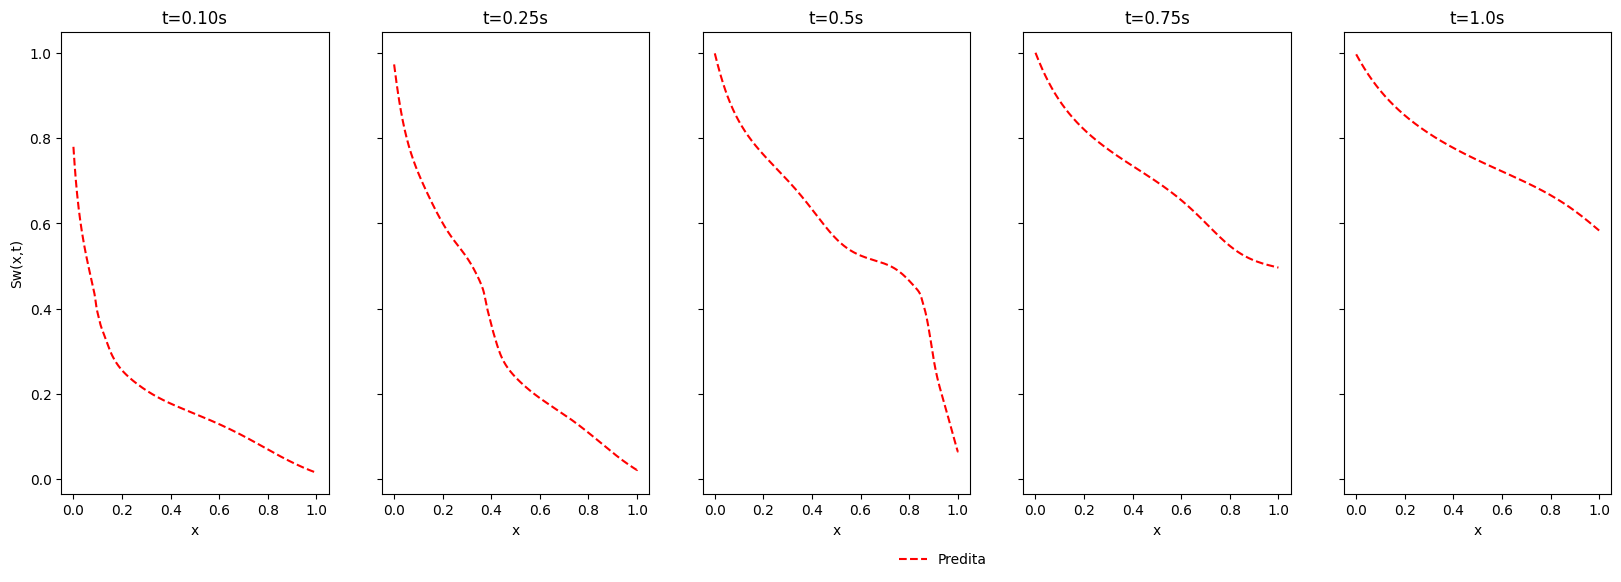

array([<Axes: title={'center': 't=0.10s'}, xlabel='x', ylabel='Sw(x,t)'>,
       <Axes: title={'center': 't=0.25s'}, xlabel='x'>,
       <Axes: title={'center': 't=0.5s'}, xlabel='x'>,
       <Axes: title={'center': 't=0.75s'}, xlabel='x'>,
       <Axes: title={'center': 't=1.0s'}, xlabel='x'>], dtype=object)

In [110]:
modelo_pinnsc.plot_momentos()

#Agora com o fator de correção

In [111]:
#E tirando os gradientes, para calcular a edp
def gradiente(modelo, X_r):
  with tf.GradientTape(persistent=True) as tape:
    t, x = X_r[:, 0:1], X_r[:,1:2]
    tape.watch(t)
    tape.watch(x)
    u = modelo(tf.stack([t[:,0], x[:,0]], 1))
    tape.watch(u)

    k_rw = ((u - Swi)/(1-Swi-Swo))**2
    k_ro = ((1- u - Swi)/(1-Swi-Swo))**2
    #f = (k_rw/u_w)/((k_rw/u_w) + (k_ro/u_o))
    #f = 1/(1+(k_ro/u_w)*(u_o/k_rw))
    f = fw(u, 2)
    f_u = tape.gradient(f,u)
    f_x = tape.gradient(f,x)

    ux = tape.gradient(u, x)
    ut = tape.gradient(u, t)
    uxx = tape.gradient(ux, x)

  del tape

  return ut + f_u*ux - (1.0e-2)*uxx

def MSE(modelo, xr, X_cond, u_cond):

    #Erro edp
    r = gradiente(modelo, xr)
    erro = tf.reduce_mean(tf.square(r))

    loss = erro

    #Erro da rede neural
    for i in range(len(X_cond)):
        u_pred = modelo(X_cond[i])
        loss += tf.reduce_mean(tf.square(u_cond[i] - u_pred))

    return erro, loss

def grad(modelo, xr, X_cond, u_cond):
  with tf.GradientTape(persistent=True) as tape:
    tape.watch(modelo.trainable_variables)
    erro, loss = MSE(modelo, xr, X_cond, u_cond)

  g = tape.gradient(loss, modelo.trainable_variables)
  del tape

  return erro, loss, g

In [112]:
modelocc = modelopinn(20,9)

lr = tf.keras.optimizers.schedules.PiecewiseConstantDecay([1000,3000],[1e-2,1e-3,5e-4])

otimizador = Adam(learning_rate = lr)

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda_17 (Lambda)          (None, 2)                 0         
                                                                 
 dense_160 (Dense)           (None, 20)                60        
                                                                 
 dense_161 (Dense)           (None, 20)                420       
                                                                 
 dense_162 (Dense)           (None, 20)                420       
                                                                 
 dense_163 (Dense)           (None, 20)                420       
                                                                 
 dense_164 (Dense)           (None, 20)                420       
                                                                 
 dense_165 (Dense)           (None, 20)              

In [113]:
@tf.function
def train_step(modelo):
  erro, loss, grad_theta = grad(modelo, xr, X_cond, u_cond)

  otimizador.apply_gradients(zip(grad_theta, modelo.trainable_variables))

  return erro, loss

itr = 5000
historico = []
erro_aux = []
t0 = time()

for i in range(itr+1):

    erro, loss = train_step(modelocc)

    #Salvando os erros para listar
    historico.append(loss.numpy())
    erro_aux.append(erro.numpy)

    if i%1 == 0:
        print(i,"Loss treino: {:10.8e}, Loss edp: {:10.8e}".format(loss, erro))

print('\nTempo de treino da rede neural: {} segundos'.format(time()-t0))

A saída de streaming foi truncada nas últimas 5000 linhas.
3 Loss treino: 9.04926777e-01, Loss edp: 1.33826938e-02
4 Loss treino: 5.93839645e-01, Loss edp: 4.80723754e-03
5 Loss treino: 4.45490927e-01, Loss edp: 1.42285645e-01
6 Loss treino: 5.69416404e-01, Loss edp: 2.80159771e-01
7 Loss treino: 4.14048195e-01, Loss edp: 2.38480810e-02
8 Loss treino: 4.97889757e-01, Loss edp: 7.40762940e-03
9 Loss treino: 5.09267509e-01, Loss edp: 3.27092945e-03
10 Loss treino: 4.36625689e-01, Loss edp: 4.11567307e-04
11 Loss treino: 3.37553799e-01, Loss edp: 7.92681240e-03
12 Loss treino: 3.62168908e-01, Loss edp: 1.20795265e-01
13 Loss treino: 3.88475448e-01, Loss edp: 1.73896879e-01
14 Loss treino: 3.01149100e-01, Loss edp: 6.85324594e-02
15 Loss treino: 2.99775720e-01, Loss edp: 2.47712564e-02
16 Loss treino: 3.25148791e-01, Loss edp: 2.23410130e-02
17 Loss treino: 3.18508029e-01, Loss edp: 1.78307258e-02
18 Loss treino: 2.88602024e-01, Loss edp: 1.13625163e-02
19 Loss treino: 2.59676486e-01, Loss

In [114]:
N = 600
tspace = np.linspace(lb[0], ub[0], N + 1)
xspace = np.linspace(lb[1], ub[1], N + 1)
T, X = np.meshgrid(tspace, xspace)
Xgrid = np.vstack([T.flatten(),X.flatten()]).T

#Realizando predição
upred = modelosc(Xgrid)

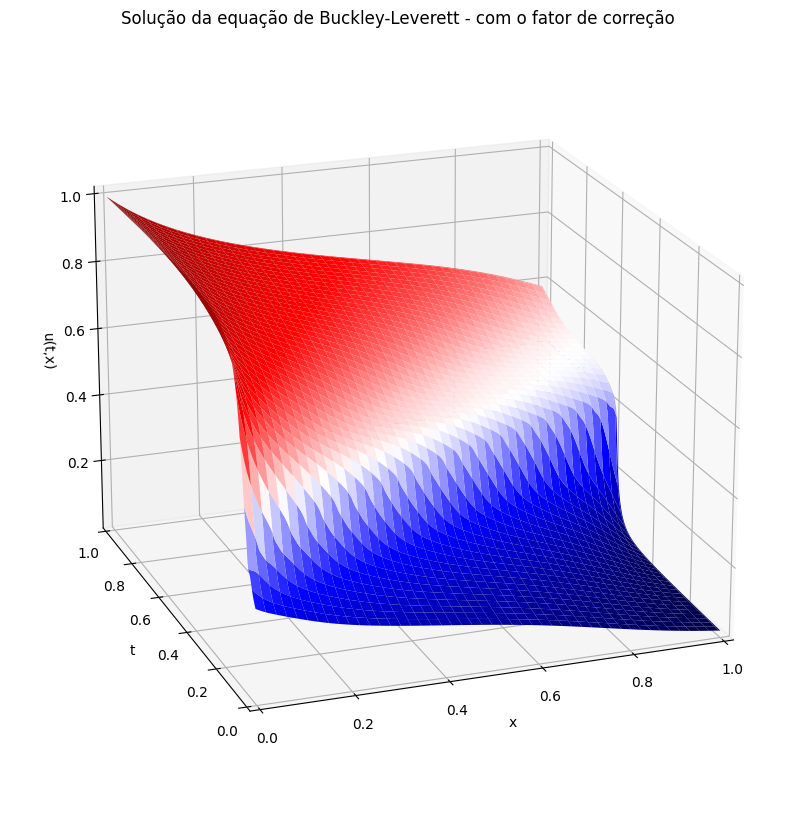

In [115]:
U = upred.numpy().reshape(N+1,N+1)
fig = plt.figure(figsize=(10,12))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, T, U, cmap='seismic');
ax.view_init(20,70)
ax.set_xlim(1,0)
ax.set_ylim(1,0)
ax.set_xlabel('x')
ax.set_ylabel('t')
ax.set_zlabel('u(t,x)')
ax.set_title('Solução da equação de Buckley-Leverett - com o fator de correção');
plt.show()

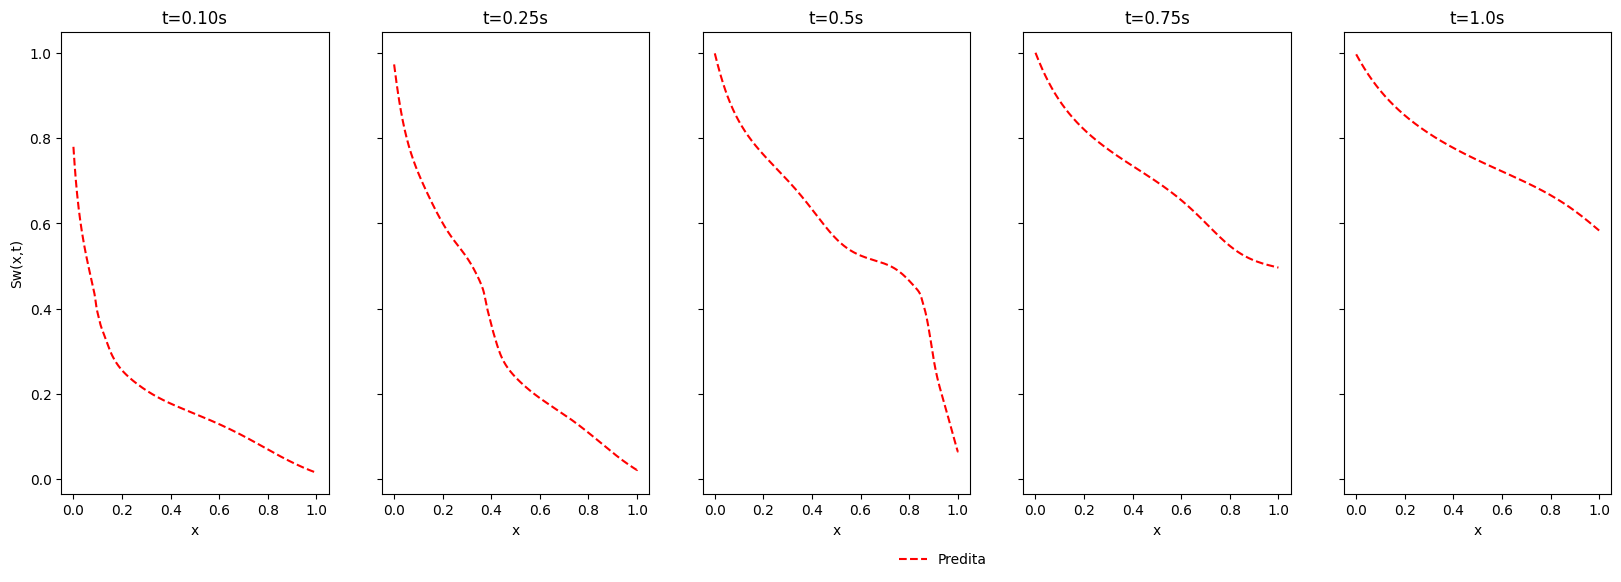

In [116]:
xspace = np.linspace(lb[1], ub[1], N + 1)

t_ini = np.ones((N+1))*0.10
T, X = np.meshgrid(t_ini, xspace)
X0 = np.vstack([T.flatten(),X.flatten()]).T

t_025 = np.ones((N+1))*0.25
T, X = np.meshgrid(t_025, xspace)
X050 = np.vstack([T.flatten(),X.flatten()]).T

t_050 = np.ones((N+1))*0.50
T, X = np.meshgrid(t_050, xspace)
X1 = np.vstack([T.flatten(),X.flatten()]).T

t_075 = np.ones((N+1))*0.75
T, X = np.meshgrid(t_075, xspace)
X15 = np.vstack([T.flatten(),X.flatten()]).T

t_1 = np.ones((N+1))*1
T, X = np.meshgrid(t_1, xspace)
X2 = np.vstack([T.flatten(),X.flatten()]).T

fig, axs = plt.subplots(1, 5, figsize=(20,6) ,sharey=True)

#axs[0].plot(xspaceana, Temp[int(t_ini[0]*passos/tmax)], c='b', label = 'Exata')
axs[0].plot(X0[:,1], modelosc(X0).numpy(), linestyle ='dashed', color='r', label = 'Predita')
axs[0].set_title('t=0.10s')
axs[0].set_xlabel('x')
axs[0].set_ylabel('Sw(x,t)')

#axs[1].plot(xspaceana, Temp[int(t_050[0]*passos/tmax)], c='b', label = 'Exata')
axs[1].plot(X050[:,1], modelosc(X050).numpy(),linestyle='dashed', color='r', label = 'Predita')
axs[1].set_title('t=0.25s')
axs[1].set_xlabel('x')

#axs[2].plot(xspaceana, Temp[int(t_1[0]*passos/tmax)], c='b', label = 'Exata')
axs[2].plot(X1[:,1], modelosc(X1).numpy(), linestyle='dashed',color='r', label = 'Predita')
axs[2].set_title('t=0.5s')
axs[2].set_xlabel('x')

#axs[3].plot(xspaceana, Temp[int(t_2[0]*passos/tmax)-1], c='b', label = 'Exata')
axs[3].plot(X2[:,1], modelosc(X15).numpy(), linestyle='dashed',color='r', label = 'Predita')
axs[3].set_title('t=0.75s')
axs[3].set_xlabel('x')

axs[4].plot(X2[:,1], modelosc(X2).numpy(), linestyle='dashed',color='r', label = 'Predita')
axs[4].set_title('t=1.0s')
axs[4].set_xlabel('x')


plt.legend(
    loc='upper center',
    bbox_to_anchor=(-1.5, -0.10),
    ncol=5,
    frameon=False
)
plt.show()

In [117]:
class PINNCC():
    def __init__(self, modelo, X_r):
        self.modelo = modelo

        #pontos de colocação da edp
        self.t = X_r[:,0:1]
        self.x = X_r[:,1:2]

        #histórico de perdas e o contador global de iterações
        self.hist = []
        self.iter = 0

    def gradiente(self):
      #Registrando tempo e posição para a diferenciação automática
        with tf.GradientTape(persistent=True) as tape:
          tape.watch(self.t)
          tape.watch(self.x)
          u = modelo(tf.stack([self.t[:,0], self.x[:,0]], axis=1))
          tape.watch(u)

          k_rw = ((u - Swi)/(1-Swi-Swo))**2
          k_ro = ((1- u - Swi)/(1-Swi-Swo))**2
          #f = (k_rw/u_w)/((k_rw/u_w) + (k_ro/u_o))
          f = fw(u, 2)
          f_u = tape.gradient(f,u)
          f_x = tape.gradient(f,self.x)

          ux = tape.gradient(u, self.x)
          ut = tape.gradient(u, self.t)
          uxx = tape.gradient(ux, self.x)

        del tape

        #return ut + ux*f_u
        return ut + f_x - (2.5e-2)*uxx

    def MSE(self, X, u):
      #Erro edp
        r = self.gradiente()
        erro = tf.reduce_mean(tf.square(r))

        loss = erro
        #Erro da rede neural
        for i in range(len(X)):
            u_pred = self.modelo(X[i])
            loss += tf.reduce_mean(tf.square(u[i] - u_pred))

        return erro, loss

    def grad(self, X, u):
      #tirando o gradiente em relação ao modelos, para que eles sejam atualizados posteriormente
        with tf.GradientTape(persistent=True) as tape:
            tape.watch(self.modelo.trainable_variables)
            erro, loss = self.MSE(X, u)

        g = tape.gradient(loss, self.modelo.trainable_variables)
        del tape

        return erro, loss, g


    def treino(self, X, u, method='L-BFGS-B', **kwargs):

        def get_weight_tensor():
            #Função para retornar variáveis atuais do modelo como tensor 1d, bem como formas correspondentes como listas.

            weight_list = []
            shape_list = []

            #loop sobre todas as variáveis, ou seja, matrizes de peso + bias e parâmetros desconhecidos
            for v in self.modelo.variables:
                shape_list.append(v.shape)
                weight_list.extend(v.numpy().flatten())

            weight_list = tf.convert_to_tensor(weight_list)
            return weight_list, shape_list

        x0, shape_list = get_weight_tensor()

        def set_weight_tensor(weight_list):
            #Função que define lista de pesos para variáveis do modelo.
            idx = 0
            for v in self.modelo.variables:
                vs = v.shape

                #Matriz do peso
                if len(vs) == 2:
                    sw = vs[0]*vs[1]
                    new_val = tf.reshape(weight_list[idx:idx+sw],(vs[0],vs[1]))
                    idx += sw

                #Vetor bias
                elif len(vs) == 1:
                    new_val = weight_list[idx:idx+vs[0]]
                    idx += vs[0]

                #Variáveis (no caso de configuração de identificação de parâmetro)
                elif len(vs) == 0:
                    new_val = weight_list[idx]
                    idx += 1

                #Atribuir variáveis (cast necessário, pois o scipy requer o tipo float64)
                v.assign(tf.cast(new_val, 'float32'))

        def get_loss_and_grad(w):
            #Função que fornece perda de custo e gradiente em relação às variáveis ​​treináveis ​​como vetor.

            #Atualizar os pesos
            set_weight_tensor(w)
            #Determinar o custo da rede neural
            erro, loss, grad = self.grad(X, u)

            #Armazenando o custo atual para a função de retorno
            loss = loss.numpy().astype(np.float64)
            self.current_loss = loss

            #Salvando os valores do gradiente
            grad_flat = []
            for g in grad:
                grad_flat.extend(g.numpy().flatten())

            #Convertendo para array
            grad_flat = np.array(grad_flat,dtype=np.float64)

            #Retornando o custo e o gradiente
            return loss, grad_flat

        #retorno, minimizando o gradiente
        return scipy.optimize.minimize(fun=get_loss_and_grad,
                                       x0=x0,
                                       jac=True,
                                       method=method,
                                       callback=self.callback,
                                       **kwargs)

    def callback(self, xr=None):
      if self.iter % 50 == 0:
        print('It {:05d}: loss = {:10.8e}'.format(self.iter,self.current_loss))
      self.hist.append(self.current_loss)
      self.iter+=1


    def solucao(self, **kwargs):
      N = 600
      tspace = np.linspace(self.modelo.lb[0], self.modelo.ub[0], N+1)
      xspace = np.linspace(self.modelo.lb[1], self.modelo.ub[1], N+1)
      T, X = np.meshgrid(tspace, xspace)
      Xgrid = np.vstack([T.flatten(),X.flatten()]).T

      #Realizando predição
      upred = self.modelo(tf.cast(Xgrid,'float32'))

      U = upred.numpy().reshape(N+1,N+1)

      fig = plt.figure(figsize=(10,12))
      ax = fig.add_subplot(111, projection='3d')
      ax.plot_surface(X, T, U, cmap='seismic');
      ax.view_init(20,70)
      ax.set_xlim(1,0)
      ax.set_ylim(1,0)
      ax.set_xlabel('x')
      ax.set_ylabel('t')
      ax.set_zlabel('u(t,x)')
      ax.set_title('Solução da equação de Buckley-Leverett');
      return ax

    def custo(self, ax=None):
      if not ax:
        fig = plt.figure(figsize=(7,5))
        ax = fig.add_subplot(111)
      ax.semilogy(range(len(self.hist)), self.hist,'k-')
      ax.set_xlabel('x')
      ax.set_ylabel('Loss')
      return ax

    def plot_momentos(self, **kwargs):
      N= 600
      xspace = np.linspace(0, 1, N + 1)

      t_ini = np.ones((N+1))*0.10
      T, X = np.meshgrid(t_ini, xspace)
      X0 = np.vstack([T.flatten(),X.flatten()]).T

      t_025 = np.ones((N+1))*0.25
      T, X = np.meshgrid(t_025, xspace)
      X050 = np.vstack([T.flatten(),X.flatten()]).T

      t_050 = np.ones((N+1))*0.50
      T, X = np.meshgrid(t_050, xspace)
      X1 = np.vstack([T.flatten(),X.flatten()]).T

      t_075 = np.ones((N+1))*0.75
      T, X = np.meshgrid(t_075, xspace)
      X15 = np.vstack([T.flatten(),X.flatten()]).T

      t_1 = np.ones((N+1))*1
      T, X = np.meshgrid(t_1, xspace)
      X2 = np.vstack([T.flatten(),X.flatten()]).T

      fig, axs = plt.subplots(1, 5, figsize=(20,6) ,sharey=True)

      #axs[0].plot(xspaceana, Temp[int(t_ini[0]*passos/tmax)], c='b', label = 'Exata')
      axs[0].plot(X0[:,1], modelosc(X0).numpy(), linestyle ='dashed', color='r', label = 'Predita')
      axs[0].set_title('t=0.10s')
      axs[0].set_xlabel('x')
      axs[0].set_ylabel('Sw(x,t)')

      #axs[1].plot(xspaceana, Temp[int(t_050[0]*passos/tmax)], c='b', label = 'Exata')
      axs[1].plot(X050[:,1], modelosc(X050).numpy(),linestyle='dashed', color='r', label = 'Predita')
      axs[1].set_title('t=0.25s')
      axs[1].set_xlabel('x')

      #axs[2].plot(xspaceana, Temp[int(t_1[0]*passos/tmax)], c='b', label = 'Exata')
      axs[2].plot(X1[:,1], modelosc(X1).numpy(), linestyle='dashed',color='r', label = 'Predita')
      axs[2].set_title('t=0.5s')
      axs[2].set_xlabel('x')

      #axs[3].plot(xspaceana, Temp[int(t_2[0]*passos/tmax)-1], c='b', label = 'Exata')
      axs[3].plot(X2[:,1], modelosc(X15).numpy(), linestyle='dashed',color='r', label = 'Predita')
      axs[3].set_title('t=0.75s')
      axs[3].set_xlabel('x')

      axs[4].plot(X2[:,1], modelosc(X2).numpy(), linestyle='dashed',color='r', label = 'Predita')
      axs[4].set_title('t=1.0s')
      axs[4].set_xlabel('x')


      plt.legend(
          loc='upper center',
          bbox_to_anchor=(-1.5, -0.10),
          ncol=5,
          frameon=False)
      plt.show()
      return axs

In [118]:
modelo = PINN_Arquitetura(lb, ub)
modelo.build(input_shape=(None,2))

modelo_pinncc = PINNCC(modelo, xr)

t0 = time()
modelo_pinncc.treino(X_cond, u_cond,
                            method='L-BFGS-B',
                            options={'maxiter': 50000,
                                     'maxfun': 50000,
                                     'maxcor': 50,
                                     'maxls': 50,
                                     'ftol': 1.0*np.finfo(float).eps})

print('\nTempo de treino da rede neural: {} segundos'.format(time()-t0))

It 00000: loss = 1.23337817e+00
It 00050: loss = 1.36343494e-01
It 00100: loss = 7.42305368e-02
It 00150: loss = 4.96518761e-02
It 00200: loss = 4.63082232e-02
It 00250: loss = 4.37019616e-02
It 00300: loss = 4.23447974e-02
It 00350: loss = 4.10567261e-02
It 00400: loss = 4.07355279e-02
It 00450: loss = 4.03225273e-02
It 00500: loss = 4.01541591e-02
It 00550: loss = 3.99767049e-02
It 00600: loss = 3.97543609e-02
It 00650: loss = 3.96244004e-02
It 00700: loss = 3.94499712e-02
It 00750: loss = 3.91368233e-02
It 00800: loss = 3.88431922e-02
It 00850: loss = 3.86233665e-02
It 00900: loss = 3.84751819e-02
It 00950: loss = 3.83073911e-02
It 01000: loss = 3.81026082e-02
It 01050: loss = 3.79159600e-02
It 01100: loss = 3.78271714e-02
It 01150: loss = 3.77831608e-02
It 01200: loss = 3.77460793e-02
It 01250: loss = 3.77056710e-02
It 01300: loss = 3.76553610e-02
It 01350: loss = 3.76283228e-02
It 01400: loss = 3.75569686e-02
It 01450: loss = 3.75315174e-02
It 01500: loss = 3.74941900e-02
It 01550

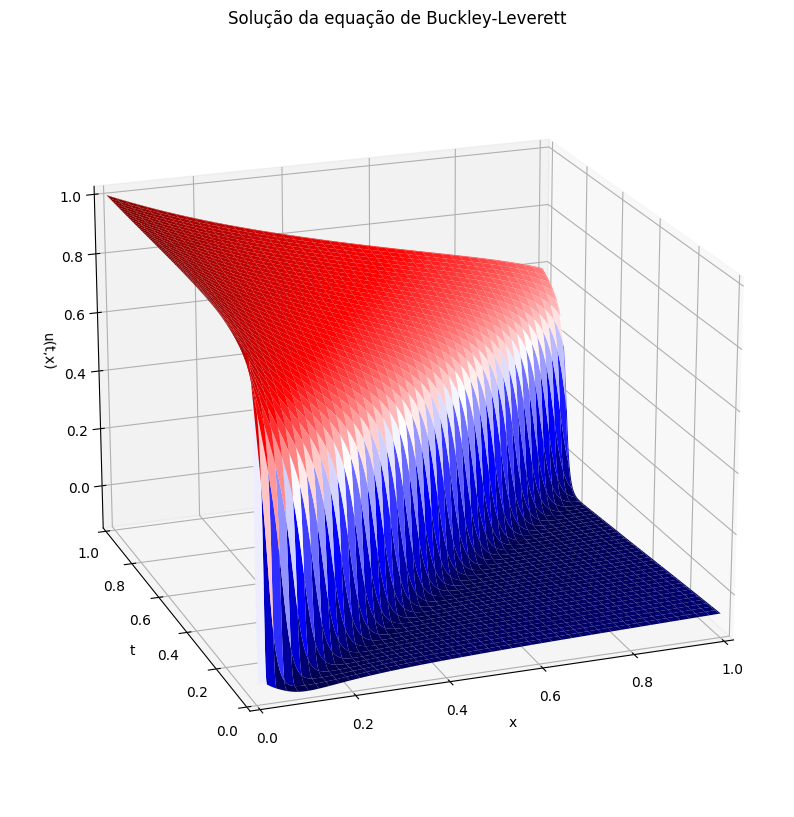

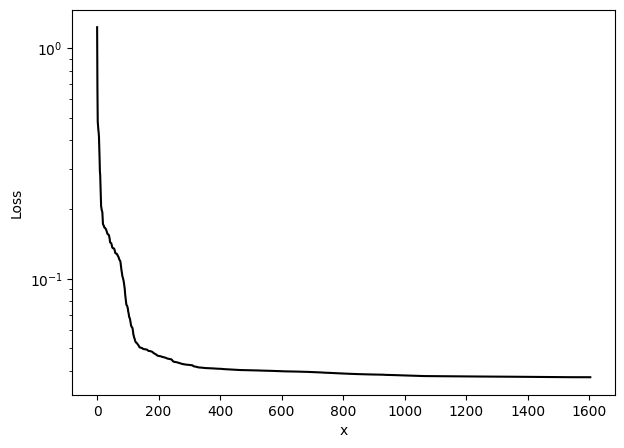

In [119]:
modelo_pinncc.solucao();
modelo_pinncc.custo();

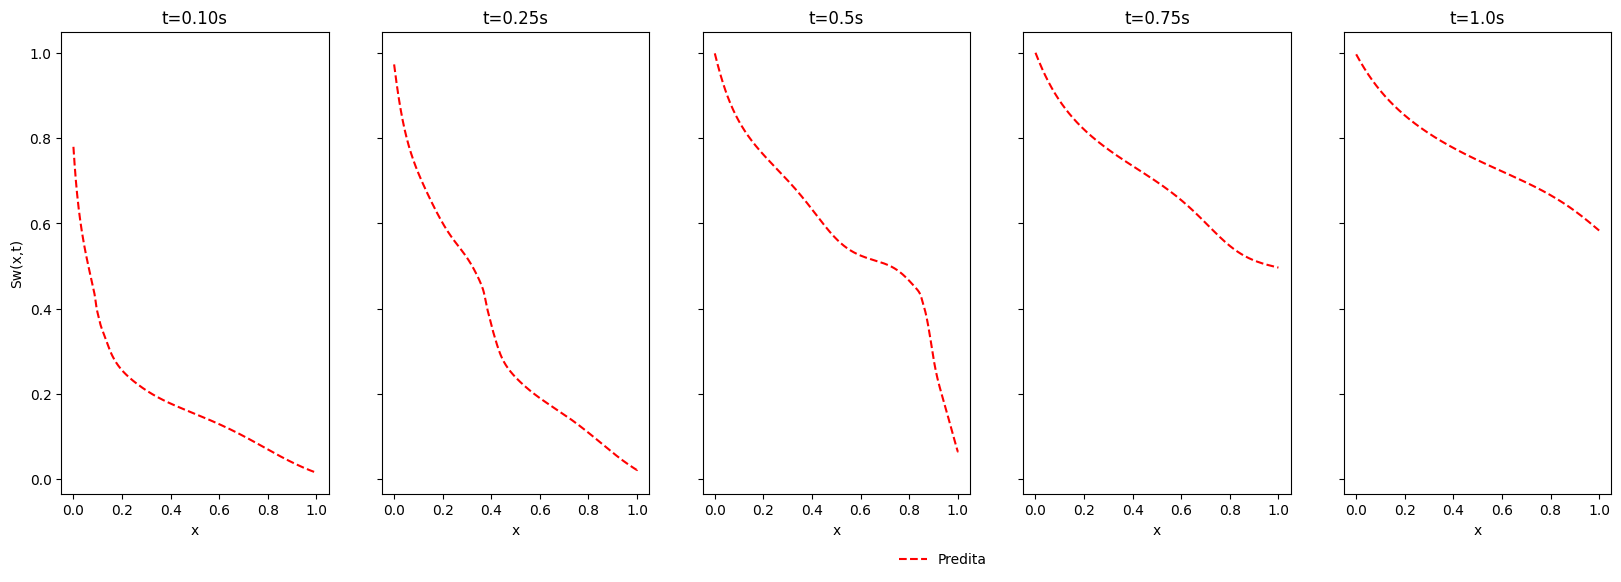

array([<Axes: title={'center': 't=0.10s'}, xlabel='x', ylabel='Sw(x,t)'>,
       <Axes: title={'center': 't=0.25s'}, xlabel='x'>,
       <Axes: title={'center': 't=0.5s'}, xlabel='x'>,
       <Axes: title={'center': 't=0.75s'}, xlabel='x'>,
       <Axes: title={'center': 't=1.0s'}, xlabel='x'>], dtype=object)

In [120]:
modelo_pinncc.plot_momentos = plot_momentos
modelo_pinncc.plot_momentos()